In [1]:
import gym

# CartPole 환경을 불러오자.
env = gym.make("CartPole-v1")

In [1]:
# 환경을 불러오면 반드시 reset() 메서드로 초기화해야한다.
obs = env.reset()

NameError: name 'env' is not defined

In [3]:
# obs의 관측은 카트의 수평 위치, 카트의 속도, 막대의 각도, 막대의 각속도를 나타낸다.
obs

array([0.03170574, 0.01362803, 0.02688148, 0.0061549 ], dtype=float32)

In [4]:
env.render()

True

In [5]:
img = env.render(mode="rgb_array")
img.shape

(800, 1200, 3)

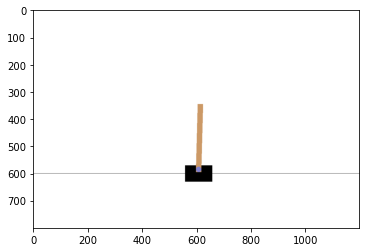

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [7]:
# 다음 코드를 통해 이 환경에서 가능한 action이 어떤 것인지 확인할 수 있다.
env.action_space
# 여기서 Discrete(2)의 의미는 가능한 action이 2가지임을 의미한다
# 0=왼쪽 1=오른쪽

Discrete(2)

In [8]:
action = 1  # 오른쪽으로 움직이자
obs, reward, done, info = env.step(action)

In [10]:
# 새로운 관측값. 
print(obs)

'''
obs[1] > 0 이므로 카트가 오른쪽 방향으로 움직인다.
obs[2] > 0 이므로 막대는 여전히 오른쪽으로 기울어져 있다.
obs[3] < 0 이므로 다음 스텝 후에는 왼쪽으로 기울어질 가능성이 크다.
'''

[ 0.03197829  0.20835435  0.02700457 -0.27792686]


'\nobs[1] > 0 이므로 카트가 오른쪽 방향으로 움직인다.\nobs[2] > 0 이므로 막대는 여전히 오른쪽으로 기울어져 있다.\nobs[3] < 0 이므로 다음 스텝 후에는 왼쪽으로 기울어질 가능성이 크다.\n'

In [11]:
# 이 환경에서는 어떤 action을 해도 reward를 1로 받는다. 
# 시스템의 목적은 가능한 오래 실행되는 것이다.
reward

1.0

In [13]:
# done이 True면 episode가 끝난 것이다.
'''
막대가 너무 기울어지거나 화면 밖으로 카트가 나가거나 200 스텝 이상 지나면 에피소드가 끝난다.
에피소드가 끝나면 환경을 다시 사용하기 전에 꼭 초기화를 해야한다.
'''
done



False

In [14]:
# info에는 디버깅이나 훈련에 유용한 추가적인 정보를 담고 있다.
info

{}

# 간단한 정책 하드코딩
막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 가속하고 오른쪽으로 기울어지면 오른쪽으로 가속하도록 하자.

In [15]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done :
            break
    totals.append(episode_rewards)

In [16]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.312, 9.350650030880207, 24.0, 72.0)

In [17]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode = "rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval = 40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames = len(frames), repeat = repeat, interval = interval)
    plt.close()
    return anim



In [19]:
plot_animation(frames)

# 18.4 Neural Net Policy

관측(Observation)을 입력으로 받고 행동(Action)을 (취할 확률을) 출력하는 Neural Network를 만들어보자.
CartPole 환경은 가능한 행동이 오른쪽, 왼쪽 두 가지만 있으므로, 한쪽 방향으로 움직일 확률을 나타낼 하나의 출력 뉴런만 있으면 된다. 

이때 행동을 Deterministic하게 하지 않고 Stochastic하게 정의하는 이유는 에이전트가 새로운 행동을 탐험(Exploring)하는 것과 잘 할 수 있는 행동을 활용(Exploiting)하는 것 사이에 균형을 맞추게 하기 위함이다.

In [30]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation = 'elu', input_shape = [n_inputs]),
    keras.layers.Dense(1, activation = 'sigmoid')
])

# 18.5 행동 평가 : 신용 할당 문제

강화학습 Agent가 얻을 수 있는 가이드는 reward 뿐이다. 
그러나 reward는 sparse하고 delayed되는 성질을 가지고 있다.
따라서 최종적으로 CartPole에서 막대가 쓰러졌다고 했을 때 어떤 행동에 의한 결과인지 알기 어렵다. 
이를 __신용 할당 문제 (Credit Assignment Problem)__ 라고 한다.

이를 해결하기 위해 Discount factor $\gamma$를 적용한 보상을 모두 합하여 행동을 평가한다.
이를 **Return**이라고 한다.
    $$G_t = \sum_{k=0}^N \gamma^k R_{t+k+1}$$

하나의 episode만 봐서는 좋은 행동 뒤에 나쁜 행동이 몇 번 뒤따라서 좋은 행동이 나쁜 reward를 받을 수도 있다.
그러나 시행착오를 충분히 많은 수만큼 반복하면 평균적으로 좋은 행동이 나쁜 행동보다 더 높은 reward를 받을 것이다. 
이를 **행동 이익(action advantage)** 이라고 부른다.
이렇게 하려면 많은 에피소드를 실행하고 모든 행동의 Return을 정규화하여 평가한다.

# 18.6 Policy Gradient

**Policy Gradient Algorithm (PG algorithm)**은 높은 보상을 얻는 방향의 Gradient를 따르도록 policy의 parameter를 최적화하는 알고리즘이다.

인기 있는 PG 알고리즘은 1992년에 발표된 **REINFORCE ALGORITHM**이다.

1. Neural Net Policy가 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 Action이 더 높은 가능성을 가지도록 만드는 Gradient를 계산한다.
2. Episode를 몇 번 실행한 다음 각 action advantage를 계산한다.
3. 한 action advantage가 양수이면 이 action이 좋은 것임을 의미하므로 미래에 선택될 가능성이 높도록 앞서 계산한 Gradient를 적용한다. 이는 각 Gradient vector와 그에 상응하는 advantage를 곱하면 된다.
4. 마지막으로 모든 결과 gradient vector를 평균 내어 GD step을 수행한다.

In [31]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames


In [32]:
frames = render_policy_net(model)
plot_animation(frames)

2022-04-19 22:48:24.155925: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-19 22:48:24.217651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [33]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.143

In [34]:
frames = render_policy_net(model)
plot_animation(frames)

In [21]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:                                     # GradientTape 블록 안에서 하나의 obs와 함께 먼저 모델을 호출한다.
        left_proba = model(obs[np.newaxis])             
        action = (tf.random.uniform([1,1]) > left_proba)                # 0-1 사이의 랜덤한 실수 하나를 샘플링 (tf.random.uniform([1,1]))한다. 이 값이 left_proba보다 큰지 확인한다.
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)    # 이 값을 계산하면 왼쪽은 0, 오른쪽은 1이 된다.
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [22]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [23]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) -2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std 
            for discounted_rewards in all_discounted_rewards]

In [24]:
discount_rewards([10, 0, -50], discount_factor = 0.8)

array([-22, -40, -50])

In [25]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor = 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [26]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [28]:
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
loss_fn = keras.losses.binary_crossentropy

In [37]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 37, mean rewards: 105.7

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)